Hi all, this is my attempt at building a spam filter from the `sms-spam-collection-dataset`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
plt.style.use('ggplot')
%matplotlib inline

First we read the csv file.

In [2]:
df = pd.read_csv('../input/sms-spam-collection-dataset/spam.csv',encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [3]:
df.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Let's examine the columns to see what is going on.

In [4]:
df[df['Unnamed: 2'].notnull()].head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


They seem to be multiple lines of text, lets add them to the same column.

In [5]:
df = df.fillna(0)

In [6]:
for index,row in df.iterrows():
    if row[2] != 0:
        df.loc[index,'v2'] = df.loc[index,'v2'] +' '+str(row[2])
        if row[3] != 0:
            df.loc[index,'v2'] = df.loc[index,'v2'] + ' '+ str(row[3])
            if row[4] != 0:
                df.loc[index,'v2'] = df.loc[index,'v2'] + ' '+ str(row[4])


  

Let's check the data.

In [7]:
df.loc[281,'v2']

'\\Wen u miss someone  the person is definitely special for u..... But if the person is so special  why to miss them  just Keep-in-touch\\" gdeve.."'

In [8]:
df[df['Unnamed: 2'] != 0].head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",0
281,ham,\Wen u miss someone the person is definitely ...,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,0,0
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool wa...,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",0,0
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",0,0


The columns have combined, now we can do our analysis and not miss out on any data!

In [9]:
cols = df.columns
cols

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [10]:
df = df.drop(cols[2:],axis=1)

Let's rename the columns for readability.

In [11]:
df = df.rename(columns={'v1': 'class','v2': 'text'})

And we can encode our predictor variable.

In [12]:
df = df.replace('ham',0) 
df = df.replace('spam',1)

In [13]:
df['class'].astype('int')

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: class, Length: 5572, dtype: int64

About 13.4% of the text messages are spam.

In [14]:
percentage_spam = df['class'].mean()
percentage_spam

0.13406317300789664

Let's look at the length of text to see whether it can predict for spam.

In [15]:
df['text_length'] = df['text'].apply(len)
df

,class,text,text_length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161
5568,0,Will Ì_ b going to esplanade fr home?,37
5569,0,"Pity, * was in mood for that. So...any other s...",57
5570,0,The guy did some bitching but I acted like i'd...,125


In [16]:
df[df['class']==0]['text_length']

0       111
1        29
3        49
4        61
6        77
       ... 
5565     12
5568     37
5569     57
5570    125
5571     26
Name: text_length, Length: 4825, dtype: int64

It looks like the mean character length for spam is higher, we should visualize this.

In [17]:
df.groupby('class').describe()

text_length                                                         
            count        mean        std   min    25%    50%    75%    max
class                                                                     
0          4825.0   71.640622  58.458559   2.0   33.0   52.0   93.0  910.0
1           747.0  139.157965  28.981074  13.0  133.0  149.0  158.0  224.0

Text(0.5, 0, 'Length of Text')

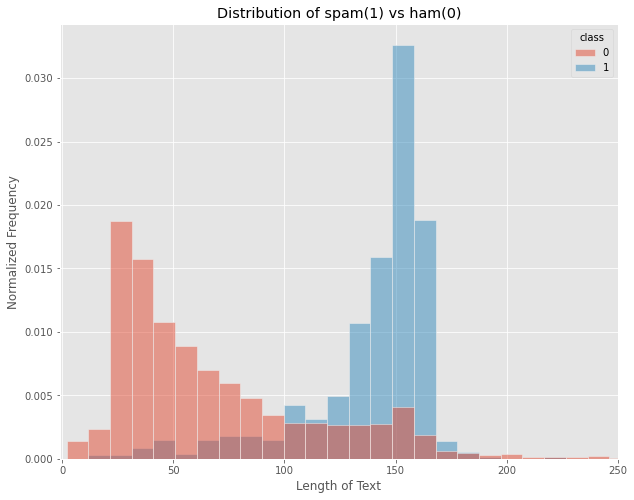

In [18]:
plt.figure(figsize=(10,8))
sns.histplot(data=df, x='text_length',hue='class',stat="density", common_norm=False)
plt.xlim(-1,250)
plt.title('Distribution of spam(1) vs ham(0)')
plt.ylabel('Normalized Frequency')
plt.xlabel('Length of Text')

Let's start building our NLP model.

In [19]:
X = df.drop('class',axis=1)
y = df['class']

In [20]:
#count_vectorizer class requires 1d X values
X_train, X_test, y_train, y_test = train_test_split(X['text'],y,test_size=0.2,random_state=42)

In [21]:
count_vectorizer = CountVectorizer(stop_words='english')

In [22]:
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

In [23]:
multi_nb = MultinomialNB()

In [24]:
multi_nb.fit(count_train,y_train)

MultinomialNB()

In [25]:
y_pred = multi_nb.predict(count_test)

In [26]:
metrics.accuracy_score(y_test,y_pred)

0.9838565022421525

This is a pretty good result as it is more then just predicting everything as spam (87%).

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.96      0.92      0.94       150

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



<AxesSubplot:>

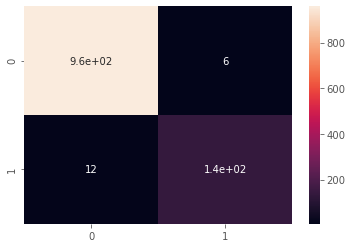

In [28]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

Let's try to optimize the model's hyperparamters even further.

In [29]:
alpha_list = np.logspace(0,200,20)
alpha_list

array([1.00000000e+000, 3.35981829e+010, 1.12883789e+021, 3.79269019e+031,
       1.27427499e+042, 4.28133240e+052, 1.43844989e+063, 4.83293024e+073,
       1.62377674e+084, 5.45559478e+094, 1.83298071e+105, 6.15848211e+115,
       2.06913808e+126, 6.95192796e+136, 2.33572147e+147, 7.84759970e+157,
       2.63665090e+168, 8.85866790e+178, 2.97635144e+189, 1.00000000e+200])

In [30]:
nb_params = {'alpha': alpha_list}

In [31]:
multi_nb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [32]:
nb_grid = GridSearchCV(multi_nb,nb_params,n_jobs=-1)

In [33]:
nb_grid.fit(count_train,y_train)

GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e+000, 3.35981829e+010, 1.12883789e+021, 3.79269019e+031,
       1.27427499e+042, 4.28133240e+052, 1.43844989e+063, 4.83293024e+073,
       1.62377674e+084, 5.45559478e+094, 1.83298071e+105, 6.15848211e+115,
       2.06913808e+126, 6.95192796e+136, 2.33572147e+147, 7.84759970e+157,
       2.63665090e+168, 8.85866790e+178, 2.97635144e+189, 1.00000000e+200])})

In [34]:
nb_grid.best_params_

{'alpha': 1.0}

Looks like the model was already using `alpha = 1.0`, this best parameter.

Thanks for reading this beginner's notebook, if you have any suggestions on how to improve my model please let me know!